## Instructions for downloading and preparing the [Kaggle Retail Products Classification](https://www.kaggle.com/competitions/retail-products-classification/data) dataset

* Visual Similarity, Matching Engine, Vetex Pipeline [Colab](https://colab.sandbox.google.com/drive/1ysjjGTv7EKkBD90dsdVD3OZvW4Oka1aC#scrollTo=_9U0deUAtD_A)

* **Note: if you are creating a Notebook instance and plan to execute vector matching online queries** with Vertex Matching Engine:
> * be sure the Notebook instance's network matches the **VPC created for Matching Engine** 
> * See [here](https://cloud.google.com/vertex-ai/docs/matching-engine/match-eng-setup#vpc-network-peering-setup) if you don't know what this means

### Setup

In [1]:
PROJECT_ID = 'hybrid-vertex'  # <--- TODO: CHANGE THIS
LOCATION = 'us-central1' 
!gcloud config set project {PROJECT_ID}

import sys

if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

Updated property [core/project].


If using Google Colab...

In [ ]:
if 'google.colab' in sys.modules:
  USER_FLAG = ''
else:
  USER_FLAG = '--user'

In [ ]:
# TODO: REMOVE THESE once complete
# ! pip3 install $USER kfp google-cloud-pipeline-components --upgrade
# !git clone https://github.com/kubeflow/pipelines.git
# !pip install pipelines/components/google-cloud/.
# !pip install google-cloud-aiplatform==1.10.0
# !pip install scann

# KEEP: packages needed
!pip install google-cloud-aiplatform==1.16.1
!pip3 install -U google-cloud-storage $USER_FLAG


# Automatically restart kernel after installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

In [2]:
! python3 -c "import google.cloud.aiplatform; print('aiplatform SDK version: {}'.format(google.cloud.aiplatform.__version__))"

aiplatform SDK version: 1.16.1


In [ ]:
# PROJECT_ID = 'hybrid-vertex'  # <--- TODO: CHANGE THIS
# LOCATION = 'us-central1' 
# !gcloud config set project {PROJECT_ID}

### Pip & Package

In [4]:
import json
import os
import time
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
# import scann

from IPython.display import clear_output, Image
from IPython.core.display import HTML 

from google.cloud import aiplatform
# from google.cloud import bigquery
from google.cloud import storage

from google import auth
# from google.colab import auth as colab_auth # if using Colab
# colab_auth.authenticate_user()

### Setup Clients

In [6]:
os.environ['GOOGLE_CLOUD_PROJECT']=PROJECT_ID

# bq_client = bigquery.Client(project=PROJECT_ID, credentials=CREDENTIALS)
storage_client = storage.Client(project=PROJECT_ID)

aiplatform.init(project=PROJECT_ID,location=LOCATION)

## Kaggle Retail Product Classification

Download the Kaggle [Retail Product Dataset](https://www.kaggle.com/c/retail-products-classification/data) and upload the zip to a Cloud Storage Bucket
* 42,000 product images and short descriptions
* 21 product categories
* Image dims = 100x100
* CSV includes
> * `title`: Name of product
> * `description`: short description of the product
> * `category`: name of the category the product belongs to

TODO:
* Create text embeddings for description, title, category, and Vision API tags (e.g., OCR)

### Unzip the files and store in Cloud Storage bucket

In [7]:
BUCKET = 'retail-products-kaggle'
ZIP_PATH = 'retail-products-classification.zip' # if the file is gs://$BUCKET/retail-products-classification.zip
DEST_FOLDER = 'data-full' # folder to place unzipped files

In [8]:
from google.cloud import storage
from zipfile import ZipFile
from zipfile import is_zipfile
import io

def zipextract(bucketname, zipfilename_with_path, destination_folder):

    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucketname)

    destination_blob_pathname = zipfilename_with_path
    
    blob = bucket.blob(destination_blob_pathname)
    zipbytes = io.BytesIO(blob.download_as_string())

    if is_zipfile(zipbytes):
        with ZipFile(zipbytes, 'r') as myzip:
            for contentfilename in myzip.namelist():
                contentfile = myzip.read(contentfilename)
                blob = bucket.blob(destination_folder + "/" + contentfilename)
                blob.upload_from_string(contentfile)

# zipextract("mybucket", "path/file.zip") # if the file is gs://mybucket/path/file.zip
zipextract(BUCKET, ZIP_PATH, DEST_FOLDER)

### Count files in GCS bucket

* Train Images = 42,001
* Test Images = 6368

In [9]:
# !gsutil du gs://retail-products-kaggle/data-full/train/train | wc -l

42001


In [10]:
# !gsutil du gs://retail-products-kaggle/data-full/test/test | wc -l

6368


### Test: compute embeddings

In [11]:
IMAGE_DIR = f'gs://{BUCKET}'
!gsutil ls $IMAGE_DIR

gs://retail-products-kaggle/retail-products-classification.zip
gs://retail-products-kaggle/data-full/
gs://retail-products-kaggle/dataset/


#### Validate image files

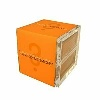

In [13]:
# gs://retail-products-kaggle/data-full/train/train/097585562X.jpg
FILE_NAME = f'{DEST_FOLDER}/train/train/097585562X.jpg' 

bucket = storage_client.get_bucket(BUCKET)
blob = bucket.blob(FILE_NAME)
Image(blob.download_as_bytes())

## Load compressed model from tensorflow_hub

In [14]:
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

### Read and decode image - return tensor

In [15]:
def read_and_decode(filename, reshape_dims=[IMG_HEIGHT, IMG_WIDTH]):
  # Read the file
  img = tf.io.read_file(filename)
  
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  # This makes the img 1 x 224 x 224 x 3 tensor with the data type of float32
  img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

In [21]:
TEST_IMG_PATH = f'gs://{BUCKET}/{FILE_NAME}'
read_and_decode(TEST_IMG_PATH)

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         ...,
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785]],

        [[0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         ...,
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785]],

        [[0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         ...,
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785]],

        ...,

        [[0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],


### Downalod TF Hub model

In [17]:
layers = [
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Flatten()
]
model = tf.keras.Sequential(layers, name='visual_embedding')
print(model.summary())

Model: "visual_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________
None


# Create embeddings dataset

In [18]:
import os.path

def create_embeddings_dataset(embedder, img_path):
    dataset_filenames = []
    dataset_embeddings = []
    list_dir = tf.io.gfile.listdir(img_path)
    for file in list_dir[:50]: # test
        img_tensor = read_and_decode(img_path + "/" + file, [IMG_WIDTH, IMG_HEIGHT])
        embeddings = embedder(img_tensor)
        dataset_filenames.append(img_path + "/" + file)
        dataset_embeddings.extend(embeddings)
  
    dataset_embeddings = tf.convert_to_tensor(dataset_embeddings)
  
    return dataset_filenames, dataset_embeddings

In [19]:
IMG_PATH = f'gs://{BUCKET}/{DEST_FOLDER}/train/train'

dataset_filenames, dataset_embeddings = create_embeddings_dataset(
    lambda x: model.predict(x),
    IMG_PATH
)

print(dataset_filenames[:3])
print(dataset_embeddings.shape) # should be (NUM_IMAGES, 1280)

['gs://retail-products-kaggle/data-full/train/train/097585562X.jpg', 'gs://retail-products-kaggle/data-full/train/train/097924837X.jpg', 'gs://retail-products-kaggle/data-full/train/train/097965856X.jpg']
(50, 1280)


## Test writting `json` for index 

In [22]:
TEST_IMG_PATH

'gs://retail-products-kaggle/data-full/train/train/097585562X.jpg'

In [33]:
gcs_uri =f'{TEST_IMG_PATH}'
print(f'gcs_uri: {gcs_uri}')

x = gcs_uri.split("/")[-1]
print(f'x: {x}')

id_ = x.split(".")[0]
print(f'id_: {id_}')

gcs_uri: gs://retail-products-kaggle/data-full/train/train/097585562X.jpg
x: 097585562X.jpg
id_: 097585562X


In [25]:
with open(f"test.json", "w") as f:
    for gcs_uri, vector in zip(dataset_filenames,dataset_embeddings):
        x = gcs_uri.split("_")[-1]
        id_ = x.split(".")[0]
        vector = vector.numpy()
        f.write('{"id":"' + str(id_) + '",')
        f.write('"embedding":[' + ",".join(str(x) for x in vector) + "]}")
        f.write("\n")

# Create Query Embeddings

In [27]:
NUM_TEST_SAMPLES = 50
EVAL_IMG_PATH = f'gs://{BUCKET}/{DEST_FOLDER}/test/test'

In [28]:
def create_query_embeddings(embedder, img_path, num_test_samples):
    dataset_filenames = []
    dataset_embeddings = []
  
    list_dir = tf.io.gfile.listdir(img_path)
  
    for file in list_dir[:num_test_samples]:
        img_tensor = read_and_decode(img_path + "/" + file, [IMG_WIDTH, IMG_HEIGHT])
        embeddings = embedder(img_tensor)
        dataset_filenames.append(img_path + "/" + file)
        dataset_embeddings.extend(embeddings)
  
    dataset_embeddings = tf.convert_to_tensor(dataset_embeddings)
  
    return dataset_filenames, dataset_embeddings

In [30]:
query_filenames, query_embeddings = create_query_embeddings(
    lambda x: model.predict(x),
    EVAL_IMG_PATH,
    NUM_TEST_SAMPLES
)

vector_list = []
for q_vector in query_embeddings:
    vector_list.append(q_vector.numpy())

# print("query_filenames:", query_filenames)
print("query_embeddings shape:", query_embeddings.shape) # should be (NUM_TEST_SAMPLES, 1280)
# print("vector_list shape:", vector_list.shape)

vector_list[0]

query_embeddings shape: (50, 1280)


array([0.08451159, 0.        , 0.00108564, ..., 0.3638365 , 0.11259918,
       0.        ], dtype=float32)

## List Index Endpoints

In [31]:
!gcloud beta ai index-endpoints list --project="hybrid-vertex" --region=us-central1

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Listed 0 items.


In [ ]:
# index_endpoint_resource_uri = 'projects/163017677720/locations/us-central1/indexEndpoints/5129564791202906112'

index_endpoint = aiplatform.MatchingEngineIndexEndpoint(index_endpoint_resource_uri)

NUM_NEIGH = 3